In [10]:
import numpy as np
#import seaborn as sns
#sns.set()
#sns.set(font_scale=1.)
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.optimize import curve_fit, nnls, leastsq
from itertools import product
from tools import parameter_instantiate as hhg 

In [11]:
######################################################################
#
# Gets the original parameters and the parameters of the tracked field
# Change these for each new field fitting
#
######################################################################

""" Hubbard Model Parameters of Tracking Field"""
L = 10  # system size
N_up = L // 2 + L % 2  # number of fermions with spin up
N_down = L // 2    # number of fermions with spin down
N = N_up + N_down  # number of particles
t0 = 0.52     # hopping strength
U = 5.0 * t0  # interaction strength
a_scale = 80
pbc = True

"""Laser pulse parameters"""
field = 32.9  # field angular frequency THz
F0 = 10       # Field amplitude MV/cm
a = a_scale * 4    # Lattice constant Angstrom


"""instantiate parameters with proper unit scaling"""
lat = hhg(field=field, nup=N_up, ndown=N_down, nx=L, ny=0, U=U, t=t0, F0=F0, a=a, pbc=pbc)


"""System Evolution Time"""
cycles = 10  # time in cycles of field frequency
n_steps = 2000
start = 0
stop = cycles / lat.freq
times, delta = np.linspace(start, stop, num=n_steps, endpoint=True, retstep=True)

Periodic Boundary conditions
5 up electrons
5 down electrons
Scaling units to energy of t_0
mu=0.000
gamma= 0.000 (t_0)^0.5
U= 5.000 t_0
SO= 0.000 t_0
t_0 = 1.000
angular frequency= 0.262
frequency= 0.042
lattice constant= 11.556
Field Amplitude= 5.325


In [12]:
######################################
#
# Loads the paths of the tracked field
#
######################################

trackfile_loc = './Data/Expectations_TrackingResults/'
loadtag = 'Trackedparams_{}sites-{}U-{}t0-{}a-{}cycles-{}steps-{}pbc'.format(
    L, U, t0, a, cycles, n_steps, pbc)

loadfile = trackfile_loc + loadtag + '.npz'

In [13]:
expectations = np.load(loadfile)

"""show the expectations available here"""
print('expectations available: {}'.format(expectations.files))

"""example for using the analysis code"""
J_field = expectations['current']
J_field_track = expectations['tracking_current']
phi = expectations['phi']
tracking_phi = expectations['tracking_phi']

expectations available: ['H', 'neighbour', 'lhopup', 'lhopdown', 'nup0', 'ndown0', 'D0', 'nup1', 'ndown1', 'D1', 'nup2', 'ndown2', 'D2', 'nup3', 'ndown3', 'D3', 'nup4', 'ndown4', 'D4', 'nup5', 'ndown5', 'D5', 'nup6', 'ndown6', 'D6', 'nup7', 'ndown7', 'D7', 'nup8', 'ndown8', 'D8', 'nup9', 'ndown9', 'D9', 'current', 'phi', 'tracking_current', 'tracking_phi', 'tracking_neighbour']


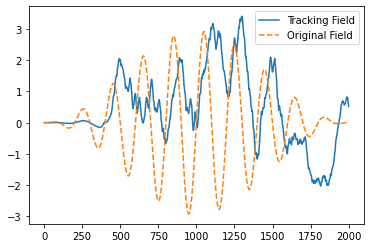

In [14]:
plt.plot(tracking_phi, label='Tracking Field')
plt.plot(phi, linestyle='--', label='Original Field')
plt.legend()
plt.show()

In [15]:
def Phi(t, f, s=0, phase=0):
    """
    Transform limited pulse 
    :param t: Time
    :param f: frequency, aim for lower values
    :param s: time delay, must be positive
    :param phase: carrier wave phase delay, prefer to change s or t than phase
    :return: Transform limited pulse with enforcement of wave starting at 0
    """
    return np.sin(t - s) ** 2 * np.sin(f * (t - s) + phase) * (t > s) * (t < (s + np.pi)) 



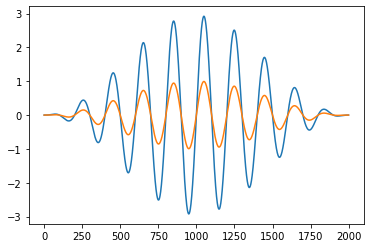

In [16]:
t = np.linspace(0, np.pi, phi.size)
plt.plot(phi)
plt.plot(Phi(t, 20))

In [17]:
# number of pulses to use
n = 4

def superoscilating_pulse(t, *args):
    
    ampl = args[:n]
    phase = args[n:]
    freq = np.linspace(10, 20, n)
    
    return sum(a * Phi(t, f, s) for a, f, s in zip(ampl, phase, freq))
    

In [18]:
popt, pcov = curve_fit(
    superoscilating_pulse, 
    t, 
    tracking_phi,
    p0=np.random.rand(2 *n),
    max_nfev=10000,
    bounds=(
        np.append(np.zeros(n), t.min() * np.ones(n)),
        np.append(np.inf * np.ones(n), t.max() * np.ones(n)),
    )
)

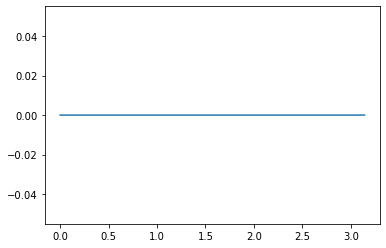

In [19]:
plt.plot(t, superoscilating_pulse(t, *popt))

In [76]:
######################################################
#
# Get best fit for Superoscillating Control Field here
#
######################################################

n = 5

fields = np.array(
    [Phi(t, f, s) for f, s in product(np.linspace(0, 20, n), np.linspace(0, np.pi, 200 * n))]
).T

In [77]:
x = lstsq(fields, tracking_phi)[0]

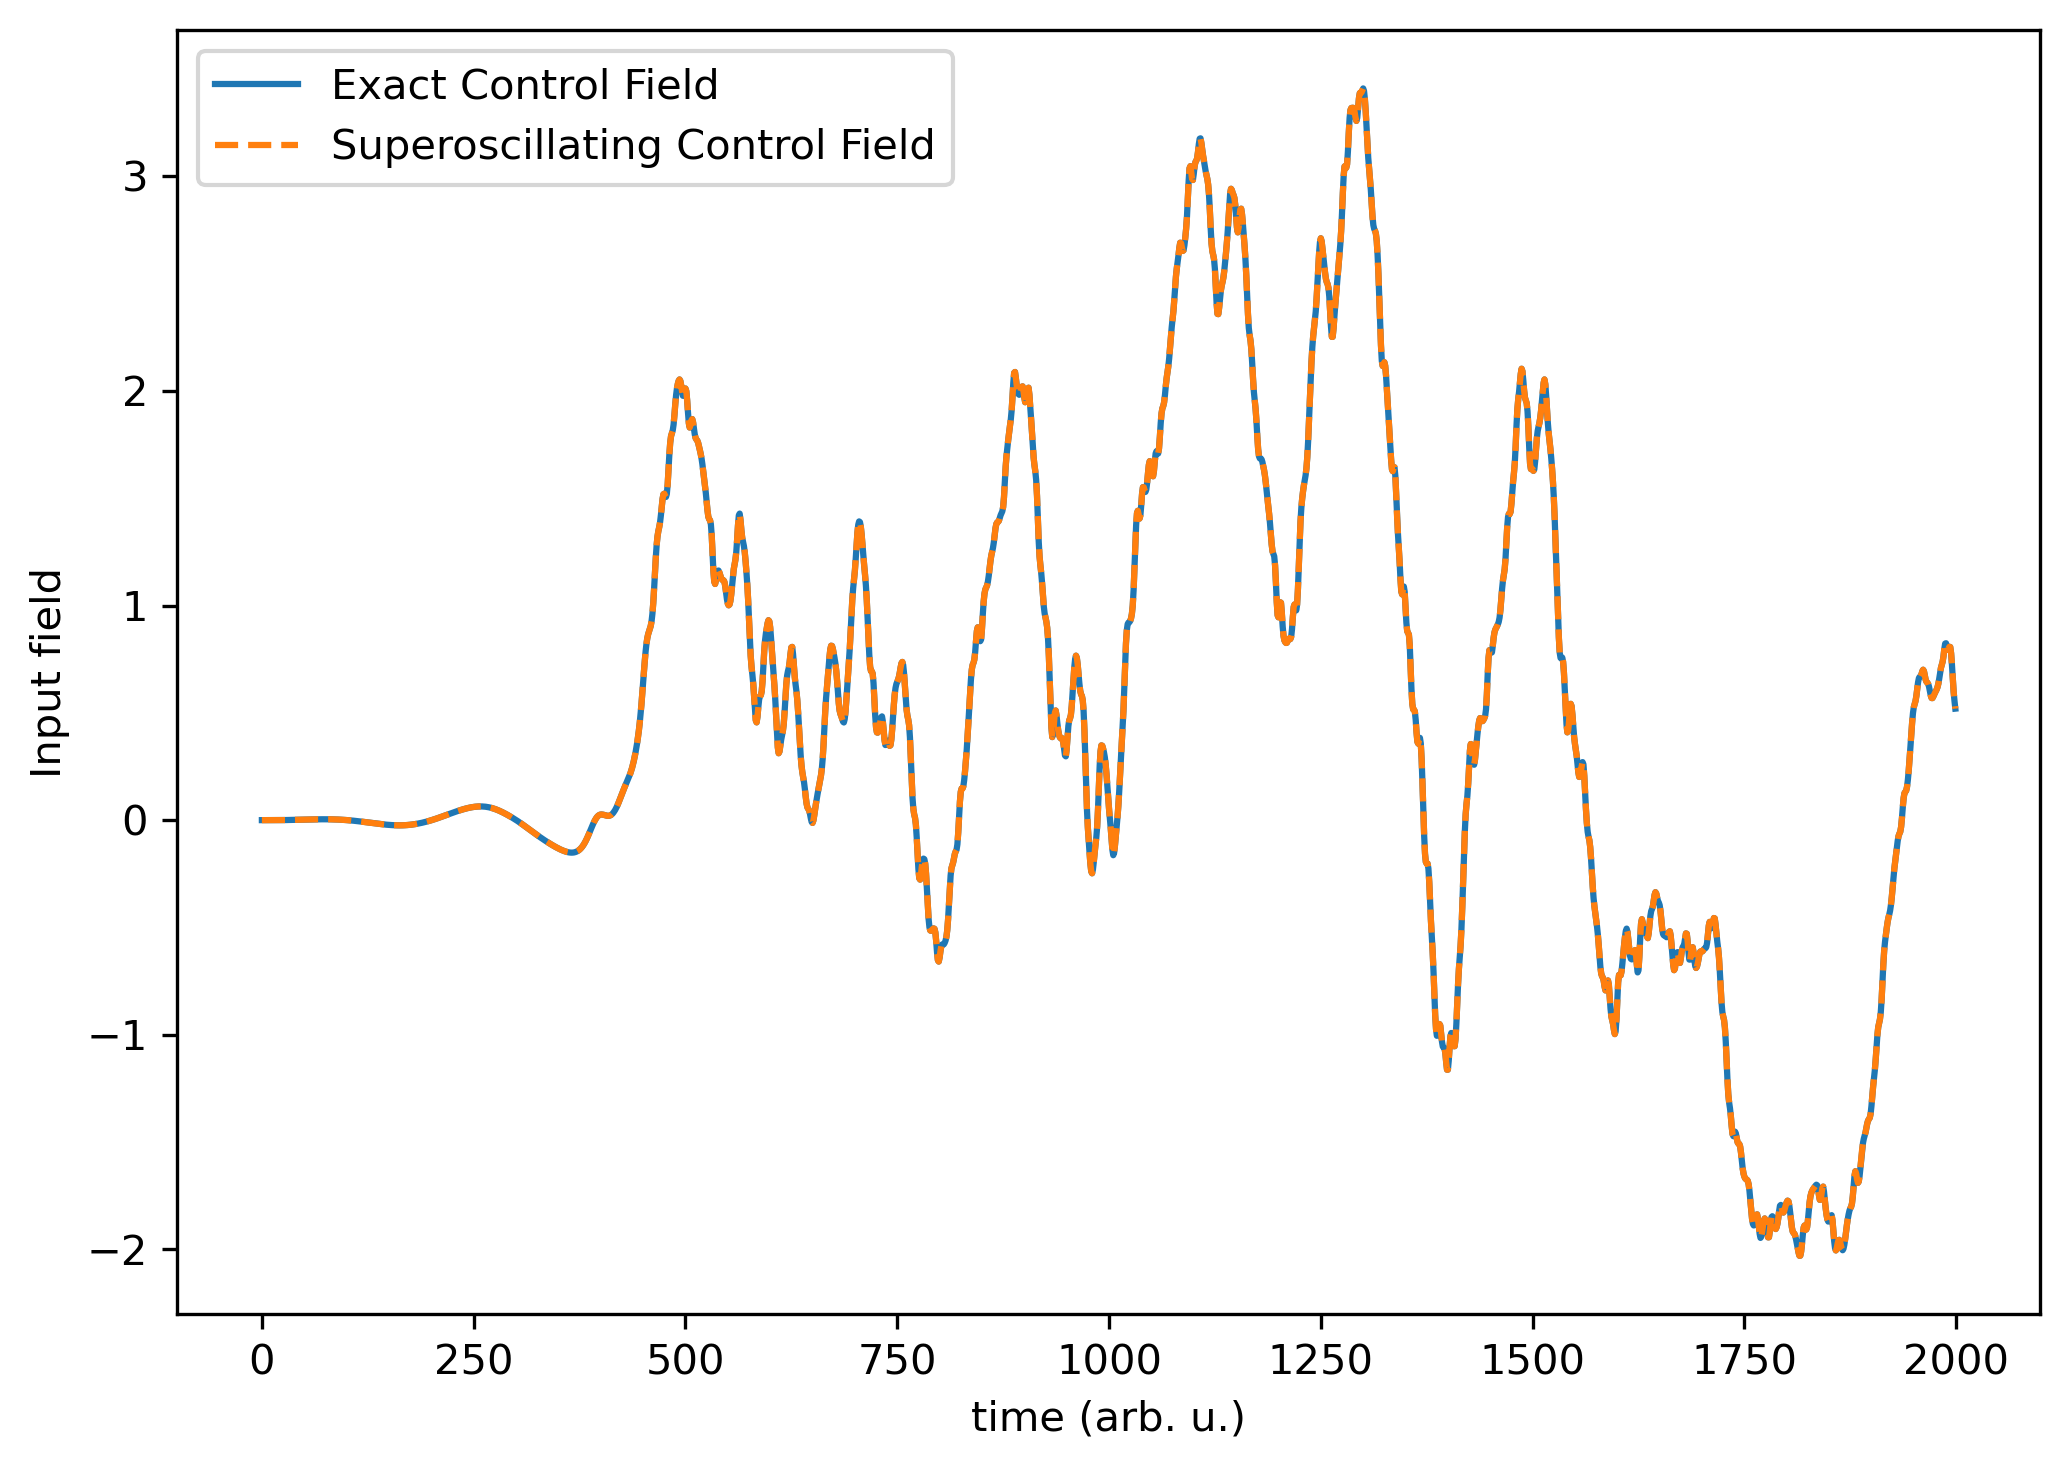

In [78]:
#plt.plot(phi, '--', color='k',label='Transform Limited Field')
plt.figure(figsize=(7, 5), dpi=300)
plt.plot(tracking_phi, label='Exact Control Field')
plt.plot(fields @ x, label='Superoscillating Control Field', linestyle='--')

plt.legend()
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig("./Plots/Comparison_plots/Test.pdf")
plt.show()

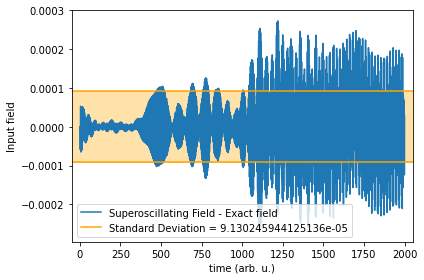

In [79]:
field_diff = (fields @ x)-tracking_phi
avg_diff = sum(field_diff) / len(field_diff)
std_dev_num = []
for _ in range(0,len(field_diff)):
    std_dev_num.append((field_diff[_] + avg_diff) ** 2)
std_dev = np.sqrt(sum(std_dev_num)/len(field_diff))

plt.plot(field_diff, label='Superoscillating Field - Exact field')
plt.axhline(y=std_dev, linestyle='-', color='orange', label='Standard Deviation = ' + str(std_dev))
plt.axhline(y=-std_dev, linestyle='-', color='orange')
plt.fill_between([-50,len(field_diff)+50], -std_dev,std_dev,facecolor="orange",
            color='orange',
        alpha=0.333)

plt.legend()
plt.xlim(-50,len(field_diff)+50)
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig("./Plots/Comparison_plots/DifferencePlot.pdf")
plt.show()

In [93]:
params = np.array(list(product(np.linspace(0, 20, n), np.linspace(0, np.pi, 200 * n))))

In [114]:
indx = np.argmax(np.abs(x[:1000]))
x[indx], params[indx]

(-41342905.80148965, array([0.        , 1.74847399]))

In [115]:
indx = 1000 + np.argmax(np.abs(x[1000:2000]))
x[indx], params[indx]

(490428830.6846448, array([5.        , 3.11957949]))

In [109]:
np.unique(params[:1000,0])

array([0.])

In [101]:
indx = np.argsort(np.abs(x))[::-1][:5]

ampl = x[indx]

omega, delay = list(zip(*params[indx]))

In [106]:
tuple(ampl), omega, delay

((-767163506.068856,
  -763641915.1128076,
  -742601051.8859222,
  739464554.6550124,
  728593498.5041468),
 (20.0, 20.0, 20.0, 20.0, 20.0),
 (3.1195794918529276,
  2.333395144107734,
  3.125868966634889,
  2.336539881498715,
  2.412013578882253))

In [103]:
omega

(20.0, 20.0, 20.0, 20.0, 20.0)

In [104]:
params.shape

(5000, 2)

In [65]:
x.shape

(5000,)

In [26]:
filetag = 'SCFparams_{}sites-{}U-{}t0-{}a-{}cycles-{}steps-{}pbc'.format(
    L, U, t0, a, cycles, n_steps, pbc)
out = './Data/BestFit_SCF/' + filetag + '.npz'
BestFitSCF = fields @ x
Points_Field = SO_field(times)
np.savez(out, field=BestFitSCF, x=x)

KeyboardInterrupt: 

In [ ]:
def SO_field(t):
    return sum(a * Phi(t, f, s) for a, f, s in product(x, np.linspace(0, 20, n), np.linspace(0, np.pi, 200 * n)))

In [ ]:
plt.semilogy(np.abs(x))
plt.show()

In [ ]:
def field(t):
    """
    return sum(
        ampl * Phi(t, f, s)
            for (f, s), ampl in zip(product(np.linspace(0, 20, n), np.linspace(0, np.pi, 200 * n)), x)
    )
    """
    return np.array(
        [Phi(t, f, s) for f, s in product(np.linspace(0, 20, n), np.linspace(0, np.pi, 200 * n))]
            ).T @ x

In [ ]:
extra_time=np.linspace(-0.25*np.pi, 1.75*np.pi, 1000)
plt.plot(extra_time,
    field(extra_time)
)
plt.axvspan(0, np.pi, color='orange', alpha=0.5)
plt.savefig("./Plots/SFC_highlighted_region")

In [31]:
print(np.linspace(0,20,5))

[ 0.  5. 10. 15. 20.]


In [ ]:
plt.plot(Phi(t, 20, s))